## Persiapan Data

In [ ]:
!pip install gdown
import gdown
gdown.download("https://docs.google.com/uc?export=download&confirm=t&id=10sfKtofHxn41NEHMc7_e5DMEwTCypvoc", 'data.csv')

Downloading...
From: https://docs.google.com/uc?export=download&confirm=t&id=10sfKtofHxn41NEHMc7_e5DMEwTCypvoc
To: /content/data.csv
100%|██████████| 4.59k/4.59k [00:00<00:00, 4.29MB/s]


'data.csv'

In [ ]:
import pandas as pd
import numpy as np

def sanitize_percentage(x):
  return float(x.split(' ')[0])

def convert_date(indonesian_date):
  month_name_to_number = {
    "Januari": 1,
    "Februari": 2,
    "Maret": 3,
    "April": 4,
    "Mei": 5,
    "Juni": 6,
    "Juli": 7,
    "Agustus": 8,
    "September": 9,
    "Oktober": 10,
    "November": 11,
    "Desember": 12
  }

  month_number = month_name_to_number[indonesian_date.split()[0]]
  year = int(indonesian_date.split()[1])

  return month_number, year

In [ ]:
df = pd.read_csv('data.csv', sep=',')

df['Data Inflasi'] = df['Data Inflasi'].apply(sanitize_percentage)
f_date = np.array([convert_date(date) for date in df['Periode']])
df['Bulan'] = f_date[:,0]
df['Tahun'] = f_date[:,1]

df = df.iloc[::-1]
# df = df[-124:]

In [ ]:
df

,Periode,Data Inflasi,Bulan,Tahun
225,Januari 2005,7.32,1,2005
224,Februari 2005,7.15,2,2005
223,Maret 2005,8.81,3,2005
222,April 2005,8.12,4,2005
221,Mei 2005,7.40,5,2005
...,...,...,...,...
4,Juni 2023,3.52,6,2023
3,Juli 2023,3.08,7,2023
2,Agustus 2023,3.27,8,2023
1,September 2023,2.28,9,2023


# Backpropagation

## Pembuatan dataset



In [ ]:
# Datas
lag_count = 12
y = np.array(df[['Data Inflasi']])
X = None

for lag in range(lag_count, 0, -1):
  if X is None:
    X = np.roll(y, lag)
  else:
    X = np.append(X, np.roll(y, lag), axis=1)

X = X[lag_count:,:]
y = y[lag_count:,:]

print(X.shape)
print(y.shape)

(214, 12)
(214, 1)


## Model Backpropagation

Model dibuat dengan 2 hidden layer menggunakan fungsi aktivasi tanh. Jumlah neuron pada hidden layer ini dapat diatur melalui argumen `h1_size` dan `h2_size` sebagai hyperparameter. Fungsi loss yang digunakan adalah MSE karena kasus yang akan adalah prediksi dengan metode regresi.

Hyperparameter lain yang dapat diatur adalah learning rate (`lr`) dan jumlah epoch. Penentuan bobot dilakukan secara acak, sedangkan bias diinisialisasi dengan nilai 0.

In [ ]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

class NeuralNetwork:
  def __init__(self, in_size, h1_size, h2_size, o_size, lr=.01):
    # Inisialisasi bobot
    self.w1 = np.random.randn(in_size, h1_size)
    self.b1 = np.zeros((1, h1_size))
    self.w2 = np.random.randn(h1_size, h2_size)
    self.b2 = np.zeros((1, h2_size))
    self.w3 = np.random.randn(h2_size, o_size)
    self.b3 = np.zeros((1, o_size))
    self.lr = lr

  def tanh(self, x):
    return np.tanh(x)

  def tanh_derivative(self, x):
    return 1.0 - np.tanh(x)**2

  def mse_loss(self, y_pred, y_true):
    return np.mean((y_pred - y_true)**2)

  def forward(self, x):
    self.layer1 = np.dot(x, self.w1) + self.b1
    self.activation1 = self.tanh(self.layer1)
    self.layer2 = np.dot(self.activation1, self.w2) + self.b2
    self.activation2 = self.tanh(self.layer2)
    self.output = np.dot(self.activation2, self.w3) + self.b3
    return self.output

  def backward(self, x, y):
    output_error = self.output - y

    dw3 = np.dot(self.activation2.T, output_error)
    db3 = np.sum(output_error, axis=0, keepdims=True)
    hidden2_error = np.dot(output_error, self.w3.T) * self.tanh_derivative(self.layer2)
    dw2 = np.dot(self.activation1.T, hidden2_error)
    db2 = np.sum(hidden2_error, axis=0, keepdims=True)
    hidden1_error = np.dot(hidden2_error, self.w2.T) * self.tanh_derivative(self.layer1)
    dw1 = np.dot(x.T, hidden1_error)
    db1 = np.sum(hidden1_error, axis=0, keepdims=True)

    self.w1 -= self.lr * dw1
    self.b1 -= self.lr * db1
    self.w2 -= self.lr * dw2
    self.b2 -= self.lr * db2
    self.w3 -= self.lr * dw3
    self.b3 -= self.lr * db3

    return self.mse_loss(self.output, y)

  def train(self, x, y, epochs):
    pbar = tqdm(range(epochs), leave=True)
    losses = []
    for epoch in pbar:
      loss = 0
      for i in range(len(x)):
        output = self.forward(x[i:i+1])
        loss += self.backward(x[i:i+1], y[i:i+1])

      avg_loss = loss / len(x)
      pbar.set_postfix({'loss': avg_loss})
      losses.append(avg_loss)
    return losses

  # def train(self, x, y, epochs):
  #   pbar = tqdm(range(epochs), leave=True)
  #   losses = []

  #   def process_data(i):
  #     output = self.forward(x[i:i+1])
  #     return self.backward(x[i:i+1], y[i:i+1])

  #   with ThreadPoolExecutor() as executor:
  #     for epoch in pbar:
  #       loss = sum(executor.map(process_data, range(len(x))))

  #       avg_loss = loss / len(x)
  #       pbar.set_postfix({'loss': avg_loss})
  #       losses.append(avg_loss)

  #   return losses

## Pelatihan Model

In [ ]:
input_size = X.shape[-1]
output_size = 1

# Hyperparameter
epoch_count = 10000
lr = .00005
h1_size = 8
h2_size = 4

model = NeuralNetwork(input_size, h1_size, h2_size, output_size, lr)
history = model.train(X, y, epoch_count)

100%|██████████| 10000/10000 [04:48<00:00, 34.66it/s, loss=0.273]


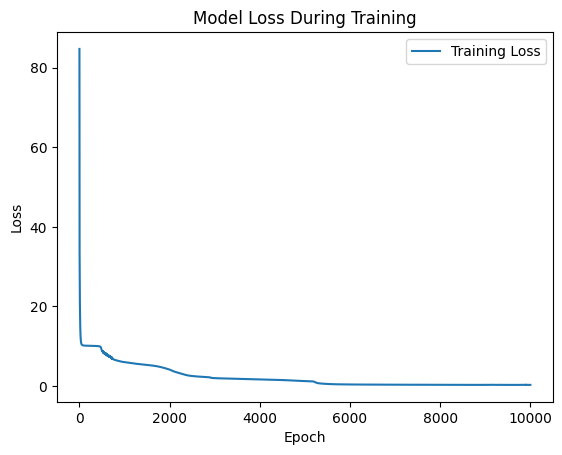

In [ ]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
plt.plot(history, label='Training Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Hasil Prediksi

In [ ]:
y_pred = model.forward(X)
print(y_pred.shape)

pred_count = 12
for _ in range(pred_count):
  n_pred = model.forward(y_pred[-lag_count:,0][None,:])
  y_pred = np.append(y_pred, n_pred, axis=0)

y_pred_only = y_pred[-12:]
print(y_pred.shape)
print(y_pred_only)

(214, 1)
(226, 1)
[[2.17944597]
 [2.23756812]
 [2.18851311]
 [2.03998209]
 [2.22319321]
 [2.25841273]
 [2.10355839]
 [2.12603225]
 [1.95280003]
 [2.12839525]
 [2.27215781]]


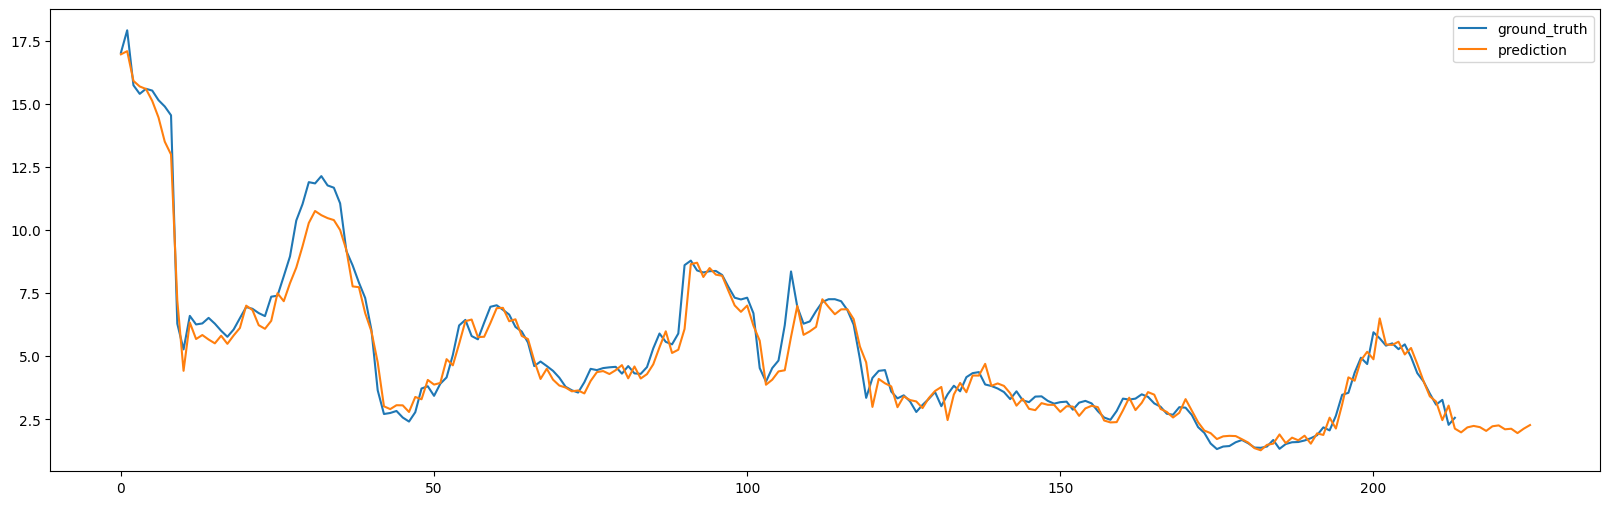

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(y, label='ground_truth')
plt.plot(y_pred, label='prediction')
plt.legend()
plt.show()